### Classificatore
Il classificatore è un modello semplice con pochi layer densi e un layer finale per la classificazione con la softmax.\
Essendo i dati molto più piccoli le batch possono essere alte e si possono avere molte più epoche per far imparare.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, callbacks
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, f1_score

root = '../..'
dataset_path = f"{root}/datasets/covid_cxr_embeddings.npz"
cache_path = f"{root}/datasets/covid_cxr_predictions.npz"
model_save_path = f"{root}/models/classifier.keras"

epochs = 100
batch = 1024

Il dataset (già modificato in embeddings) viene caricato in modo da avere in input le rappresentazioni latenti delle immagini e la classe a cui appartiene.

In [24]:
dataset = np.load(dataset_path, allow_pickle=True)

x_train = dataset['x_train']
y_train = dataset['y_train']
x_val = dataset['x_val']
y_val = dataset['y_val']
x_test = dataset['x_test']
y_test = dataset['y_test']

latent_space = x_train.shape[1]

Purtroppo essendo il dataset molto sbilanciato verso una classe l'addestramento viene influenzato negativamente se non si fanno delle correzioni.

Train samples: 67863, Validation samples: 8473, Test samples: 8482
Train shape: (67863, 1024), Validation shape: (8473, 1024), Test shape: (8482, 1024)


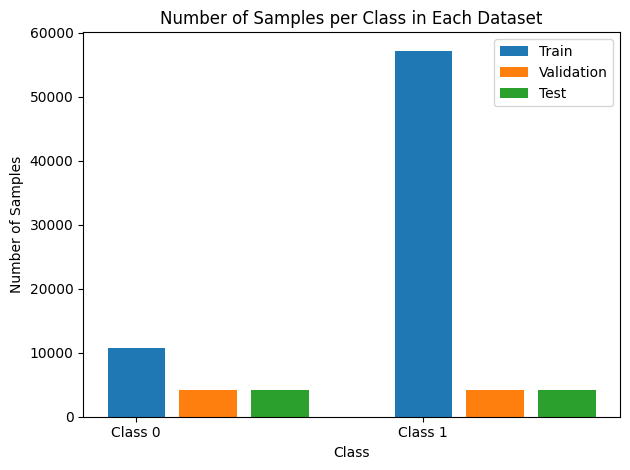

In [25]:
train_counts = np.bincount(y_train)
val_counts = np.bincount(y_val)
test_counts = np.bincount(y_test)

print(f"Train samples: {len(y_train)}, Validation samples: {len(y_val)}, Test samples: {len(y_test)}")
print(f"Train shape: {x_train.shape}, Validation shape: {x_val.shape}, Test shape: {x_test.shape}")

total_classes = len(train_counts)
class_weights = {i: len(y_train) / (total_classes * count) for i, count in enumerate(train_counts)}

plt.figure()
x_labels = range(total_classes)
plt.bar(x_labels, train_counts, width=0.2, label='Train', align='center')
plt.bar([x + 0.25 for x in x_labels], val_counts, width=0.2, label='Validation', align='center')
plt.bar([x + 0.5 for x in x_labels], test_counts, width=0.2, label='Test', align='center')
plt.xticks(x_labels, [f"Class {i}" for i in x_labels])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Each Dataset')
plt.legend()
plt.tight_layout()
plt.show()

La struttura del classificatore.\
Questo modello verrà valutato tramite *sparse_categorical_crossentropy* dato che restituirà un array con le probabilità per ogni classe.

In [26]:
in_classifier = layers.Input(shape=(latent_space,), dtype='float32')
x = layers.BatchNormalization()(in_classifier)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(8)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
out_classifier = layers.Dense(total_classes, activation='softmax')(x)

classifier = models.Model(in_classifier, out_classifier, name='classifier')
classifier.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,794 (1.09 MB)

 Trainable params: 282,090 (1.08 MB)

 Non-trainable params: 2,704 (10.56 KB)

In questa porzione di codice il modello viene addestrato

In [27]:
history = classifier.fit(x_train, y_train, validation_data=(x_val, y_val),
                         epochs=epochs,
                         batch_size=batch, class_weight=class_weights,
                         callbacks=[callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.6918 - loss: 0.4974 - val_accuracy: 0.5030 - val_loss: 1.0847
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8525 - loss: 0.3525 - val_accuracy: 0.5024 - val_loss: 1.2504
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8827 - loss: 0.3178 - val_accuracy: 0.5862 - val_loss: 0.8159
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.2977 - val_accuracy: 0.5828 - val_loss: 0.9716
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8995 - loss: 0.2822 - val_accuracy: 0.6851 - val_loss: 0.7485
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9053 - loss: 0.2692 - val_accuracy: 0.8112 - val_loss: 0.4237
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9124 - loss: 0.2525 - val_accuracy: 0.5731 - val_loss: 1.2319
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9096 - loss: 0.2536 - val_accuracy: 0.8731 - 

Di seguito la loss nel tempo

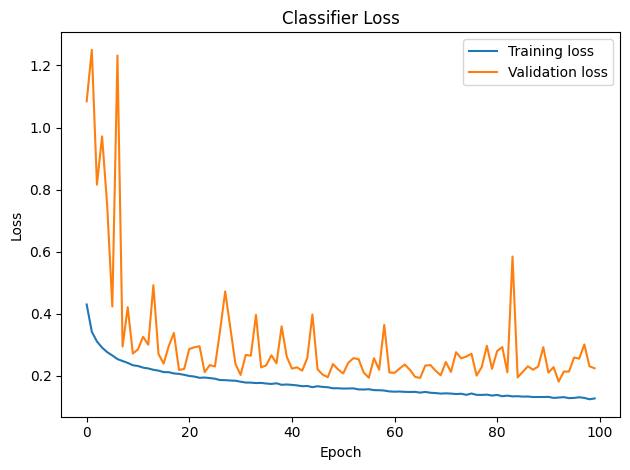

In [28]:
plt.figure(figsize=None)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title(f'Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Il risultato è che il classificatore riesce a distinguere abbastanza bene nella parte di training mentre fallisce nel generalizzare

2121/2121 ━━━━━━━━━━━━━━━━━━━━ 2s 926us/step
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


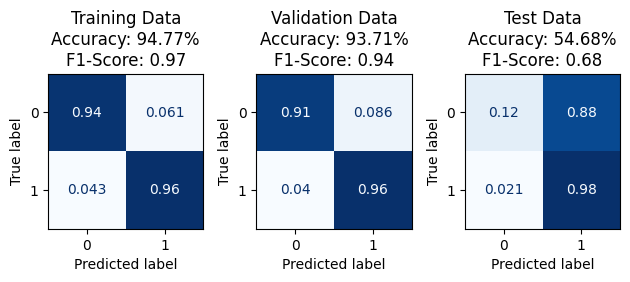

In [29]:
classifier = models.load_model(model_save_path)

y_train_pred = np.argmax(classifier.predict(x_train), axis=1)
y_val_pred = np.argmax(classifier.predict(x_val), axis=1)
y_test_pred = np.argmax(classifier.predict(x_test), axis=1)

datasets = [
    ("Training Data", y_train, y_train_pred),
    ("Validation Data", y_val, y_val_pred),
    ("Test Data", y_test, y_test_pred)
]

_, axes = plt.subplots(1, len(datasets), figsize=None)
for i, (title, y_true, y_pred) in enumerate(datasets):
    ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        normalize='true',
        display_labels=[i for i in range(total_classes)],
        cmap=plt.cm.Blues,
        colorbar=False,
        ax=axes[i]
    )
    axes[i].set_title(f"{title}\n"
                        + f"Accuracy: {balanced_accuracy_score(y_true, y_pred):.2%}\n"
                        + f"F1-Score: {f1_score(y_true, y_pred):.2f}")
plt.tight_layout()
plt.show()

In [30]:
# Save the embeddings predictions and true labels
print(f"Shapes: "
      f"x_train: {x_train.shape}, y_train: {y_train.shape}, y_train_pred: {y_train_pred.shape}\n"
      f"x_val: {x_val.shape}, y_val: {y_val.shape}, y_val_pred: {y_val_pred.shape}\n"
      f"x_test: {x_test.shape}, y_test: {y_test.shape}, y_test_pred: {y_test_pred.shape}\n"
      f"latent_space: {latent_space}, total_classes: {total_classes}, class_weights: {class_weights}")

np.savez(cache_path,
         y_train_pred=y_train_pred,
         y_val_pred=y_val_pred,
         y_test_pred=y_test_pred)

Shapes: x_train: (67863, 1024), y_train: (67863,), y_train_pred: (67863,)
x_val: (8473, 1024), y_val: (8473,), y_val_pred: (8473,)
x_test: (8482, 1024), y_test: (8482,), y_test_pred: (8482,)
latent_space: 1024, total_classes: 2, class_weights: {0: np.float64(3.1818735933983495), 1: np.float64(0.5932184129093167)}
